In [1]:
import os
import sys
import imp
import json
import onnx
import torch
import urllib
import onnxruntime
import numpy as np
import torchvision.models
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms


In [2]:
CUDA=False
EXPORT=False
def preprocess_image_to_batch(input_image):
    preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    return input_batch
def run_through_model(input_image,model):
    #preprocessing image 
    input_batch = preprocess_image_to_batch(input_image)
    if torch.cuda.is_available() and CUDA:
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    result = (output[0])
    # running softmax to get probabilities
    result = torch.nn.functional.softmax(result, dim=0)
    return result

In [3]:
# source https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html
def export_model_to_onnx(model,sample_input,export_path):
    torch.onnx.export(
                  model,
                  sample_input,
                  export_path,
                  export_params=True,
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}}
                     )
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def verify_onnx_export(torch_model,sample_input,export_path):
    #verification
    onnx_model = onnx.load(export_path)
    onnx.checker.check_model(onnx_model)

    # check if outputs are close
    torch_out = torch_model(sample_input)
    ort_session = onnxruntime.InferenceSession(export_path)

    # compute ONNX Runtime output prediction
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(sample_input)}
    ort_outs = ort_session.run(None, ort_inputs)

    # compare ONNX Runtime and PyTorch results
    np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

    print("Verified")

## Resnet50 V1.50

In [4]:
imagenet_map = json.load(open("imagenet_class_index.json"))
model = torchvision.models.resnet34(pretrained=True, progress=True)
model.eval() #putting model in eval mode

filename = './car.jpeg'
input_image = Image.open(filename)
result = run_through_model(input_image,model)

prediction = torch.argmax(result).item()
predicted_label = imagenet_map[str(prediction)][1]


## Inference using Torch

Input Image
AxesImage(54,36;334.8x217.44)
Prediction :  sports_car


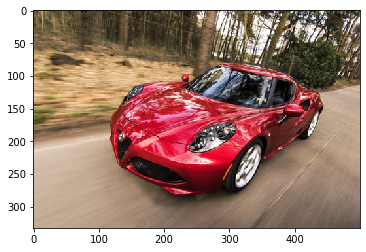

In [5]:
print("Input Image")
print(plt.imshow(input_image))
print("Prediction : ",predicted_label)

In [6]:
sample_input = preprocess_image_to_batch(input_image)
export_path = "./exported_models/resnetv1.5_224.onnx"

#exporting model to onnx
if EXPORT:
    export_model_to_onnx(model = model,
                        sample_input = sample_input,
                        export_path = export_path)
#verifying
verify_onnx_export(torch_model = model,
                    sample_input = sample_input,
                    export_path = export_path)

Verified


## Inference using ONNX

Input Image
AxesImage(54,36;334.8x217.44)
Prediction :  sports_car


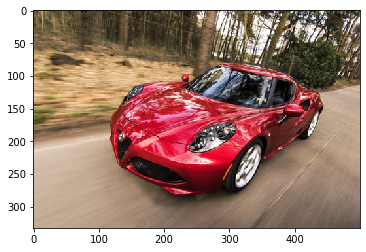

In [7]:
# inference using onnx model
onnx_model = onnx.load(export_path)
onnx.checker.check_model(onnx_model)


ort_session = onnxruntime.InferenceSession(export_path)

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(sample_input)}
ort_outs = ort_session.run(None, ort_inputs)

prediction = np.argmax(ort_outs[0]).item()
predicted_label = imagenet_map[str(prediction)][1]

print("Input Image")
print(plt.imshow(input_image))
print("Prediction : ",predicted_label)

## MobileNet V1 224

In [8]:
ckpt_path = "./pretrained_models/mobilenetv1/pytorch/tf_mobilenetv1_224_to_pytorch.pth"
# required by mmdnn to load model
MainModel = imp.load_source('MainModel', "./pretrained_models/mobilenetv1/pytorch/tf_mobilenetv1_224_to_pytorch.py")
model = torch.load(ckpt_path)
model.eval() #putting model in eval mode

filename = "./dog.jpg"
input_image = Image.open(filename)
result = run_through_model(input_image,model)

prediction = torch.argmax(result).item()
predicted_label = imagenet_map[str(prediction)][1]



/home/aghinsa/anaconda3/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'MainModel.KitModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
./pretrained_models/mobilenetv1/pytorch/tf_mobilenetv1_224_to_pytorch.py:184: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  MobilenetV1_Predictions_Softmax = F.softmax(MobilenetV1_Predictions_Reshape)


## Inference using Torch

Input Image
AxesImage(54,36;334.8x217.44)
Prediction :  Pomeranian


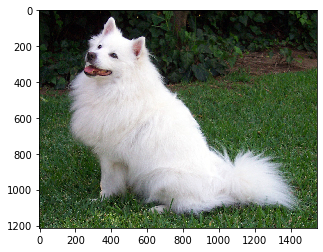

In [9]:
print("Input Image")
print(plt.imshow(input_image))
print("Prediction : ",predicted_label)

In [10]:
sample_input = preprocess_image_to_batch(input_image)
export_path = "./exported_models/mobilenetv1_224.onnx"
if EXPORT:
    torch.onnx.export(
                  model,
                  sample_input,
                  export_path,
                  export_params=True,
                  opset_version=7,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}}
                     )

In [11]:
onnx_model = onnx.load(export_path)
onnx.checker.check_model(onnx_model)

## Inference using ONNX

Input Image
AxesImage(54,36;334.8x217.44)
Prediction :  Pomeranian


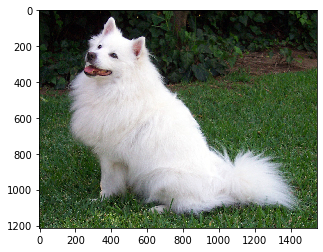

In [12]:
#inference using onnx

ort_session = onnxruntime.InferenceSession(export_path)

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(sample_input)}
ort_outs = ort_session.run(None, ort_inputs)

prediction = np.argmax(ort_outs[0]).item()
predicted_label = imagenet_map[str(prediction)][1]

print("Input Image")
print(plt.imshow(input_image))
print("Prediction : ",predicted_label)

## SSD-ResNet34 COCO (1200x1200)

In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
from object_detection_utils import draw_bounding_box_on_image
models_src_path= "./inference-master/v0.5/classification_and_detection/python/"
sys.path.insert(0,models_src_path) 
from models.ssd_r34 import SSD_R34,dboxes_R34_coco,Encoder


In [15]:
def preprocess_image_to_batch(input_image,img_size):
    preprocess = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    return input_batch

In [16]:
ckpt_path = "./pretrained_models/resnet34-ssd1200.pth"
model_state,label_dict = torch.load(ckpt_path).values()

model = SSD_R34(extract_shapes=True)
model.load_state_dict(model_state)
model.eval()


filename = "000000010707.jpg"
input_image = Image.open(filename)

img_size= [1200,1200]
input_image = input_image.resize(img_size)
input_batch = preprocess_image_to_batch(input_image,img_size)

if torch.cuda.is_available() and CUDA :
    input_batch = input_batch.to('cuda')
    model.to('cuda')
    
with torch.no_grad():
    locs,confs,feature_shapes= model(input_batch)
    
dboxes = dboxes_R34_coco(img_size, [3, 3, 2, 2, 2, 2])
encoder = Encoder(dboxes)
#low criteria -> high confidence
boxes, labels, scores = encoder.decode_batch(locs,confs,criteria=0.05, max_output=5)
boxes = boxes[0]
labels = labels[0]

## Inference using Torch

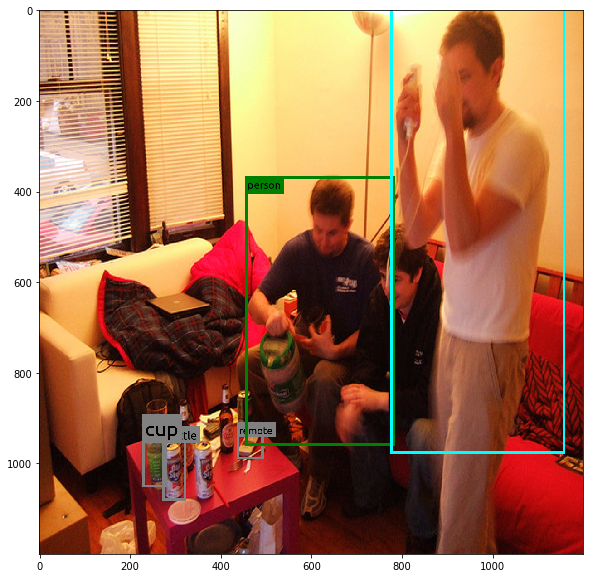

In [17]:
for box,label in zip(boxes,labels):
    box = box.cpu().detach().numpy()
    label = label_dict[label.item()]
    draw_bounding_box_on_image(input_image, box, label)

fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.imshow(input_image)

In [18]:
sample_input = preprocess_image_to_batch(input_image,img_size)
export_path = "./exported_models/ssd_resnet34_1200.onnx"

#exporting model to onnx
if EXPORT :
    torch.onnx.export(
                  model,
                  sample_input,
                  export_path,
                  export_params=True,
                  opset_version=7,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}}
                     )


In [19]:
# inference using onnx
onnx_model = onnx.load(export_path)
onnx.checker.check_model(onnx_model)


ort_session = onnxruntime.InferenceSession(export_path)

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(sample_input)}
ort_outs = ort_session.run(None, ort_inputs)

torch_out = model(sample_input)

## Inference using ONNX

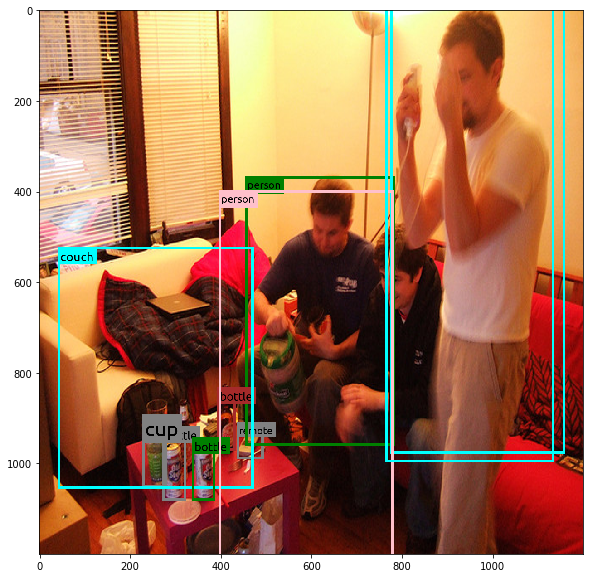

In [20]:
locs,confs,*_= ort_outs
locs = torch.Tensor(locs)
confs = torch.Tensor(confs)

boxes, labels, scores = encoder.decode_batch(locs,confs,criteria=0.05, max_output=5)
boxes = boxes[0]
labels = labels[0]

for box,label in zip(boxes,labels):
    box = box.cpu().detach().numpy()
    label = label_dict[label.item()]
    draw_bounding_box_on_image(input_image, box, label)

fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.imshow(input_image)

## SSD-MobileNets-v1 (300x300)

In [21]:
from object_detection_utils import draw_bounding_box_on_image
models_src_path= "./pytorch-ssd"
sys.path.insert(0,models_src_path) 
from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd, create_mobilenetv1_ssd_predictor

from vision.utils import box_utils


In [22]:
def preprocess_image_to_batch(input_image,img_size):
    preprocess = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    return input_batch
def predict(scores,boxes,height=300,width=300, top_k=-1,nms_method=None,
            prob_threshold=0.09,iou_threshold=0.5,sigma=0.01,candidate_size=200):
    """
    input transformed image
    """
    cpu_device = torch.device("cpu")
    boxes = boxes[0]
    scores = scores[0]

    # this version of nms is slower on GPU, so we move data to CPU.
    boxes = boxes.to(cpu_device)
    scores = scores.to(cpu_device)
    picked_box_probs = []
    picked_labels = []
    for class_index in range(1, scores.size(1)):
        probs = scores[:, class_index]
        mask = probs > prob_threshold
        probs = probs[mask]
        if probs.size(0) == 0:
            continue
        subset_boxes = boxes[mask, :]
        box_probs = torch.cat([subset_boxes, probs.reshape(-1, 1)], dim=1)
        box_probs = box_utils.nms(box_probs, nms_method,
                                  score_threshold=prob_threshold,
                                  iou_threshold=iou_threshold,
                                  sigma=sigma,
                                  top_k=top_k,
                                  candidate_size=candidate_size)
        picked_box_probs.append(box_probs)
        picked_labels.extend([class_index] * box_probs.size(0))
    if not picked_box_probs:
        return torch.tensor([]), torch.tensor([]), torch.tensor([])
    picked_box_probs = torch.cat(picked_box_probs)
    picked_box_probs[:, 0] *= width
    picked_box_probs[:, 1] *= height
    picked_box_probs[:, 2] *= width
    picked_box_probs[:, 3] *= height
    return picked_box_probs[:, :4], torch.tensor(picked_labels), picked_box_probs[:, 4]

In [23]:
label_path="./voc-model-labels.txt"
class_names = [name.strip() for name in open(label_path).readlines()]
num_classes = len(class_names)

model = create_mobilenetv1_ssd(num_classes, is_test=True,device="cpu")
model.load("./pretrained_models/mobilenet-v1-ssd-mp-0_675.pth")
model.eval()

filename = "000000001584.jpg"
input_image = Image.open(filename)
img_size= [300,300]
input_image = input_image.resize(img_size)
input_batch = preprocess_image_to_batch(input_image,img_size)

with torch.no_grad():
    out_scores,out_boxes= model(input_batch)

boxes,labels,probs=predict(out_scores,out_boxes)
labels = list(map(lambda x:label_dict[x.item()],labels))



## Inference using Torch

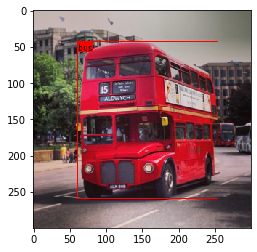

In [24]:
for box,label in zip(boxes,labels):
    box = box.cpu().detach().numpy()
    draw_bounding_box_on_image(input_image, box, label,scale=False)
plt.imshow(input_image)

In [25]:
sample_input = preprocess_image_to_batch(input_image,img_size)
export_path = "./exported_models/ssd_mobilenetv1_300.onnx"

if EXPORT:
    torch.onnx.export(
                  model,
                  sample_input,
                  export_path,
                  export_params=True,
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}}
                     )

In [26]:
# inference using onnx
onnx_model = onnx.load(export_path)
onnx.checker.check_model(onnx_model)


ort_session = onnxruntime.InferenceSession(export_path)

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(sample_input)}
ort_outs = ort_session.run(None, ort_inputs)



## Inference using ONNX

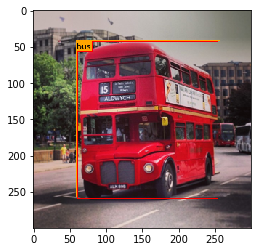

In [27]:
out_scores,out_boxes= ort_outs
out_scores=torch.Tensor(out_scores)
out_boxes=torch.Tensor(out_boxes)

boxes,labels,probs=predict(out_scores,out_boxes)
labels = list(map(lambda x:label_dict[x.item()],labels))

for box,label in zip(boxes,labels):
    draw_bounding_box_on_image(input_image, box, label,scale=False)
plt.imshow(input_image)

## GNMT WMT16

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
models_src_path= "./training/rnn_translator/pytorch/" #path to seq2seq
sys.path.insert(0,models_src_path) 

from seq2seq import models
from seq2seq.inference.inference import Translator
import seq2seq.data.config as config
from seq2seq.data import tokenizer
from ast import literal_eval
from seq2seq.models.gnmt import GNMT
from seq2seq.data.dataset import ParallelDataset
from seq2seq.inference.beam_search import SequenceGenerator

In [30]:
ckpt_path="./pretrained_models/gnmt.pth"
setattr(tokenizer,'default',lambda :int(config.UNK))
checkpoint = torch.load(ckpt_path, map_location={'cuda:0': 'cpu'})

vocab_size = checkpoint['tokenizer'].vocab_size
model_config = dict(vocab_size=vocab_size,
                    **literal_eval(checkpoint['config'].model_config))
model_config['batch_first'] = True
model = GNMT(**model_config)
state_dict = checkpoint['state_dict']
model.load_state_dict(state_dict)

if torch.cuda.is_available() and CUDA :
    model.to('cuda')

model.eval()

tokenizer = checkpoint['tokenizer']
args = {
        "beam_size":5,
       "max_seq_len":80,
       "len_norm_factor":0.6,
       "len_norm_const":5.0,
       "cov_penalty_factor":0.1,
       "cuda":(torch.cuda.is_available() and CUDA),
        "batch_size":128,
        "batch_first":True
       }
config.TGT_TEST_FNAME = "newstest2014.tok.bpe.32000.de"
dataset_dir = "./"

test_data = ParallelDataset(
        src_fname=os.path.join(dataset_dir, config.SRC_TEST_FNAME),
        tgt_fname=os.path.join(dataset_dir, config.TGT_TEST_FNAME),
        tokenizer=tokenizer,
        min_len=0,
        max_len=150,
        sort=False)

test_loader = test_data.get_loader(batch_size=args["batch_size"],
                                   batch_first=args["batch_first"],
                                   shuffle=False,
                                   num_workers=0)

translator = Translator(model,
                       tokenizer,
                       loader=test_loader,
                       beam_size=args["beam_size"],
                       max_seq_len=args["max_seq_len"],
                       len_norm_factor=args["len_norm_factor"],
                       len_norm_const=args["len_norm_const"],
                       cov_penalty_factor=args["cov_penalty_factor"],
                       cuda=args["cuda"])

output = []
input_corpus = []
loader = test_loader
beam_size = args["beam_size"]
batch_size = args["batch_size"]
batch_first = args["batch_first"]
cuda = args["cuda"]
generator = SequenceGenerator(
            model=model,
            beam_size=beam_size,
            cuda=cuda,
        )

:::MLPv0.5.0 gnmt 1581704833.602252483 (./training/rnn_translator/pytorch/seq2seq/models/gnmt.py:41) model_hp_num_layers: 4
:::MLPv0.5.0 gnmt 1581704833.611447334 (./training/rnn_translator/pytorch/seq2seq/models/gnmt.py:42) model_hp_hidden_size: 1024
:::MLPv0.5.0 gnmt 1581704833.622555017 (./training/rnn_translator/pytorch/seq2seq/models/gnmt.py:43) model_hp_dropout: 0.2
:::MLPv0.5.0 gnmt 1581704836.053183794 (./training/rnn_translator/pytorch/seq2seq/data/sampler.py:254) input_order


DEBUG:mlperf_compliance::::MLPv0.5.0 gnmt 1581704836.053183794 (./training/rnn_translator/pytorch/seq2seq/data/sampler.py:254) input_order


:::MLPv0.5.0 gnmt 1581704836.063802719 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:50) eval_hp_beam_size: 5


DEBUG:mlperf_compliance::::MLPv0.5.0 gnmt 1581704836.063802719 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:50) eval_hp_beam_size: 5


:::MLPv0.5.0 gnmt 1581704836.075959921 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:52) eval_hp_max_sequence_length: 80


DEBUG:mlperf_compliance::::MLPv0.5.0 gnmt 1581704836.075959921 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:52) eval_hp_max_sequence_length: 80


:::MLPv0.5.0 gnmt 1581704836.087132931 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:55) eval_hp_length_normalization_constant: 5.0


DEBUG:mlperf_compliance::::MLPv0.5.0 gnmt 1581704836.087132931 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:55) eval_hp_length_normalization_constant: 5.0


:::MLPv0.5.0 gnmt 1581704836.097472668 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:60) eval_hp_length_normalization_factor: 0.6


DEBUG:mlperf_compliance::::MLPv0.5.0 gnmt 1581704836.097472668 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:60) eval_hp_length_normalization_factor: 0.6


:::MLPv0.5.0 gnmt 1581704836.108817339 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:65) eval_hp_coverage_penalty_factor: 0.1


DEBUG:mlperf_compliance::::MLPv0.5.0 gnmt 1581704836.108817339 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:65) eval_hp_coverage_penalty_factor: 0.1


:::MLPv0.5.0 gnmt 1581704836.119456053 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:50) eval_hp_beam_size: 5


DEBUG:mlperf_compliance::::MLPv0.5.0 gnmt 1581704836.119456053 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:50) eval_hp_beam_size: 5


:::MLPv0.5.0 gnmt 1581704836.128023624 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:52) eval_hp_max_sequence_length: 100


DEBUG:mlperf_compliance::::MLPv0.5.0 gnmt 1581704836.128023624 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:52) eval_hp_max_sequence_length: 100


:::MLPv0.5.0 gnmt 1581704836.138738871 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:55) eval_hp_length_normalization_constant: 5


DEBUG:mlperf_compliance::::MLPv0.5.0 gnmt 1581704836.138738871 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:55) eval_hp_length_normalization_constant: 5


:::MLPv0.5.0 gnmt 1581704836.152134418 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:60) eval_hp_length_normalization_factor: 0.6


DEBUG:mlperf_compliance::::MLPv0.5.0 gnmt 1581704836.152134418 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:60) eval_hp_length_normalization_factor: 0.6


:::MLPv0.5.0 gnmt 1581704836.162775993 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:65) eval_hp_coverage_penalty_factor: 0.1


DEBUG:mlperf_compliance::::MLPv0.5.0 gnmt 1581704836.162775993 (./training/rnn_translator/pytorch/seq2seq/inference/beam_search.py:65) eval_hp_coverage_penalty_factor: 0.1


In [31]:
src_compare =[]
tgt_compare =[]
sample_input = None
for i, (src, tgt) in enumerate(test_loader):
    src, src_length = src
    tgt,tgt_length = tgt
    for i in range(len(src)):
        src_compare.append(src[i].tolist())
        tgt_compare.append(tgt[i].tolist())
    if translator.batch_first:
        batch_size = src.size(0)
    else:
        batch_size = src.size(1)

    bos = [config.BOS] * (batch_size * beam_size)
    bos = torch.LongTensor(bos)
    if translator.batch_first:
        bos = bos.view(-1, 1)
    else:
        bos = bos.view(1, -1)

    src_length = torch.LongTensor(src_length)

    if cuda:
        src = src.cuda()
        src_length = src_length.cuda()
        bos = bos.cuda()
        
    with torch.no_grad():
        context = translator.model.encode(src, src_length)
        context = [context, src_length, None]
        if sample_input is None:
            sample_input = (src,src_length,src_length)
        if beam_size == 1:
            generator = translator.generator.greedy_search
        else:
            print("Using beam search")
            generator = translator.generator.beam_search
        preds, lengths, counter = generator(batch_size, bos, context)


    preds = preds.cpu()
    lengths = lengths.cpu()

    output = []
    for idx, pred in enumerate(preds):
        end = lengths[idx] - 1
        pred = pred[1: end]
        pred = pred.tolist()
        out = translator.tokenizer.detokenize(pred)
        output.append(out)
    break

Using beam search


In [32]:

# for proper output on exporting as pdf
def pprint(s,n_in_line=10):
    s=s.split()
    print("\t",end="")
    for i,word in enumerate(s,1):
        if i%n_in_line==0:
            print()
        else:
            print(word,end=" ")
    print("\n")

## Inference using Torch

In [33]:
src_compare = [translator.tokenizer.detokenize(x) for x in src_compare]
tgt_compare = [translator.tokenizer.detokenize(x) for x in tgt_compare]
    
print("Input corpus:")
pprint(src_compare[0])
print("Ground truth :")
pprint(tgt_compare[0])
print("Prediction :")
pprint(output[0])

Input corpus:
	According to Arnold , every possible test was carried 
prior to the selection of the location for the 
light posts : &quot; Using a goods vehicle loaded 
particularly long tree trunks , we also tested whether 
vehicles could access the B 33 from the Sul<unk> 
without knocking over the traffic light posts &quot; . 

Ground truth :
	Es wurde laut Arnold bei der Standortwahl der Ampelmasten 
alles ausgetestet : &quot; Mittels eines extra für uns 
besonders langen Holzstämmen beladener Transporter haben wir <unk> estet 
ob diese Fahrzeuge aus dem Sul<unk> achweg auf die 
33 ausfahren können , ohne den Ampelmasten umzuknicken &quot; 


Prediction :
	Laut Arnold war jeder mögliche Test vor der Auswahl 
Standortes für die Ampeln ausgeführt : &quot; Mit einem 
, das mit besonders langen Baumwollsteinen geladen wurde , 
wir auch untersucht , ob solche Fahrzeuge die B 
vom Sulve-Bahnhof überqueren konnten . 

